In [1]:
%pylab inline
from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

Populating the interactive namespace from numpy and matplotlib


# Helper functions

In [2]:
#Figure params
rcParams['figure.figsize'] = 16, 8
rcParams.update({'font.size': 22})

#helper functions
def hist(data=None, plot=True, ran=1.0):
    
    ig = data[0]
    qg = data[1]
    ie = data[2]
    qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -np.arctan2((ye-yg),(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*np.cos(theta) - qg*np.sin(theta)
    qg_new = ig*np.sin(theta) + qg*np.cos(theta) 
    ie_new = ie*np.cos(theta) - qe*np.sin(theta)
    qe_new = ie*np.sin(theta) + qe*np.cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)
    
    #print(xg, xe)
    
    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='lower right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
        axs[2].set_xlabel('I(a.u.)')       
        
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    contrast = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum())))
    tind=contrast.argmax()
    threshold=binsg[tind]
    fid = contrast[tind]
    axs[2].set_title(f"Fidelity = {fid*100:.2f}%")

    return fid, threshold, theta

# Configuring the channels

In [3]:
# Load bitstream with custom overlay
soc = QickSoc()
soc.set_nyquist(ch=7,nqz=1) #JPA
soc.set_nyquist(ch=6,nqz=1) #Readout
soc.set_nyquist(ch=3,nqz=2) #Qubit
soc.set_nyquist(ch=1,nqz=2) #Storage

hw_cfg={"res_ch":6,
        "qubit_ch":3,
        "jpa_ch":1,
        "storage_ch":1
       }
readout_cfg={
    "readout_length":us2cycles(3), # [Clock ticks]
    "f_res": adcfreq(99.775 +0.18), # [MHz]
    "res_phase": 0,
    "adc_trig_offset": 275, # [Clock ticks]
    "res_gain":10000
    }
qubit_cfg={
    "sigma":us2cycles(0.025),
    "pi_gain": 11500,
    "pi2_gain":11500//2, 
    "f_ge":4743.041802067813,
    "relax_delay":500
}

# TOF Measurement

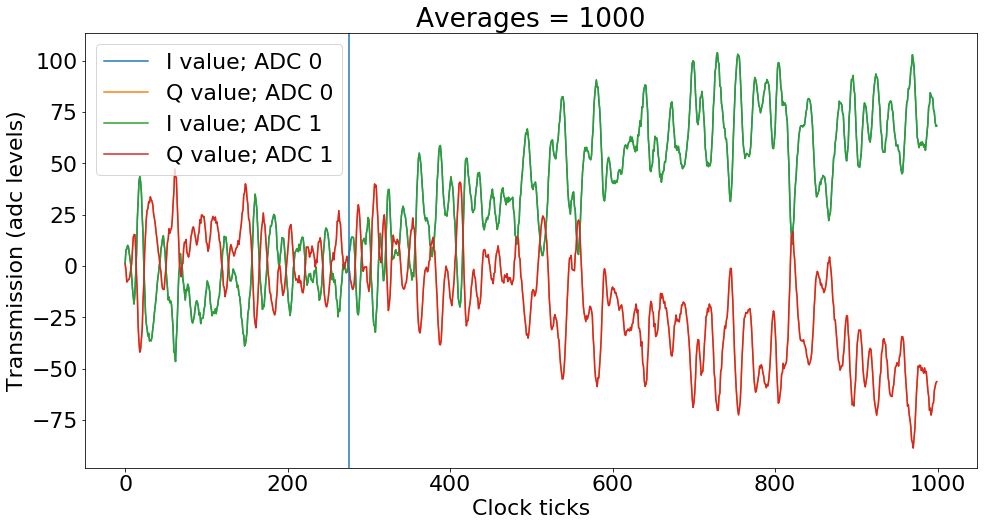

In [4]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        cfg["adc_lengths"]=[cfg["readout_length"]]*2          #add length of adc acquisition to config
        cfg["adc_freqs"]=[adcfreq(cfg["frequency"])]*2   #add frequency of adc ddc to config
        
        self.add_pulse(ch=cfg["res_ch"], name="measure", style="const", length=cfg["pulse_length"])  #add a constant pulse to the pulse library
        
        self.freq=freq2reg(adcfreq(cfg["frequency"]))  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        cfg=self.cfg   
        self.trigger_adc(adc1=1, adc2=1,adc_trig_offset=cfg["adc_trig_offset"])  # trigger the adc acquisition
        self.pulse(ch=cfg["res_ch"], name="measure", freq=self.freq, phase=0, gain=cfg["pulse_gain"],  length=cfg['pulse_length'], t= 0, play=True) 
        self.sync_all(us2cycles(self.cfg["relax_delay"]))  # sync all channels

expt_config={
        "reps":1, # --Fixed
        "pulse_length":600, # [Clock ticks]
        "readout_length":1000, # [Clock ticks]
        "pulse_gain":5000, # [DAC units]
        "frequency": 100, # [MHz]
        "adc_trig_offset": 0, # [Clock ticks]
        "soft_avgs":1000
       }

config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_config}
prog =LoopbackProgram(config)
di, dq = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)

# Plot results.
subplot(111, title=f"Averages = {config['soft_avgs']}", xlabel="Clock ticks", ylabel="Transmission (adc levels)")
plot(di[0], label="I value; ADC 0")
plot(dq[0], label="Q value; ADC 0")
plot(di[1], label="I value; ADC 1")
plot(dq[1], label="Q value; ADC 1")
legend()
axvline(readout_cfg["adc_trig_offset"])

# Single tone (Resonator) Spectroscopy

In [5]:
class SingleToneSpectroscopyProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2          #add length of adc acquisition to config
        self.cfg["adc_freqs"]=[adcfreq(self.cfg["frequency"])]*2   #add frequency of adc ddc to config
        
        self.add_pulse(ch=self.cfg["res_ch"], name="measure", style="const", length=self.cfg["readout_length"])  #add a constant pulse to the pulse library of res_ch
        freq=freq2reg(adcfreq(cfg["frequency"]))  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        
        self.pulse(ch=cfg["res_ch"], name="measure", freq=freq, phase=0, gain=cfg["res_gain"],  length=self.cfg['readout_length'], t= 0, play=False) # pre-configure readout pulse
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger_adc(adc1=1, adc2=1,adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        self.pulse(ch=self.cfg["res_ch"], play=True) # play readout pulse
        self.sync_all(us2cycles(self.cfg["relax_delay"]))  # sync all channels

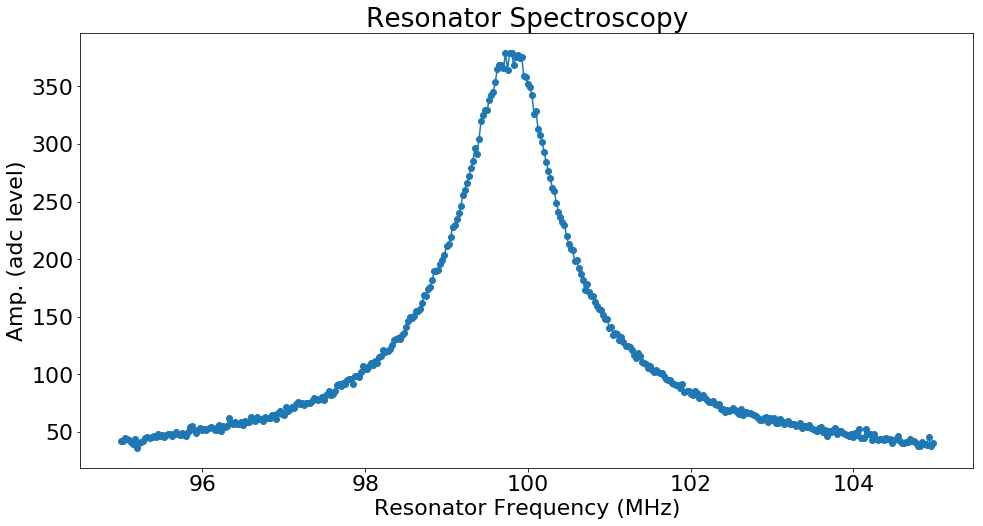

In [6]:
expt_cfg={"reps":500, "relax_delay":10,
          "start":95, "step":0.025, "expts":400
         }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs

fpts=expt_cfg["start"] + expt_cfg["step"]*np.arange(expt_cfg["expts"])

amps=[]
for f in tqdm(fpts):
    config["frequency"]=f

    rspec=SingleToneSpectroscopyProgram(config)
    avgi,avgq=rspec.acquire(soc, load_pulses=True)
    amp=np.abs(avgi[0][0]+1j*avgq[0][0])
    amps.append(amp)
amps=np.array(amps)

plt.subplot(111,title="Resonator Spectroscopy", xlabel="Resonator Frequency (MHz)", ylabel="Amp. (adc level)")
plt.plot(fpts, amps,'o-')
max_freq=fpts[np.argmax(amps)]
plt.show()

# Single Shot

In [7]:
class SingleShotProgram(RAveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)       
        
    def initialize(self):
        cfg=self.cfg
        
        cfg["start"]=0
        cfg["step"]=cfg["pi_gain"]
        cfg["reps"]=cfg["shots"]
        cfg["expts"]=2
        
        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_gain=self.sreg(cfg["qubit_ch"], "gain")   # get frequency register for qubit_ch    
        
        f_res=freq2reg(adcfreq(cfg["f_res"]))            # conver f_res to dac register value
        f_ge=freq2reg(cfg["f_ge"])
        
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2   #copy over adc acquisition parameters
        self.cfg["adc_freqs"]=[adcfreq(cfg["f_res"])]*2
        
        # add qubit and readout pulses to respective channels
        self.add_pulse(ch=self.cfg["qubit_ch"], name="qubit",style="arb", 
                       idata=gauss(mu=cfg["sigma"]*16*4/2,si=cfg["sigma"]*16,length=4*cfg["sigma"]*16,maxv=2**15-1),
                       qdata=0*gauss(mu=cfg["sigma"]*16*4/2,si=cfg["sigma"]*16,length=4*cfg["sigma"]*16,maxv=2**15-1))
        self.add_pulse(ch=self.cfg["res_ch"], name="measure",style="const", length=self.cfg["readout_length"])
               
        # pre-initialize pulses
        self.pulse(ch=cfg["qubit_ch"], name="qubit", phase =0, freq=f_ge, gain=cfg["start"], play=False)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], play=False)
    
        self.sync_all(us2cycles(500))
    
    def body(self):
        
        self.pulse(ch=self.cfg["qubit_ch"], play=True)  #play probe pulse
        self.sync_all(us2cycles(0.05)) # align channels and wait 50ns
        self.trigger_adc(adc1=1, adc2=1, adc_trig_offset=self.cfg["adc_trig_offset"])  #trigger measurement
        self.pulse(ch=self.cfg["res_ch"], name="measure", play=True) # play measurement pulse

        self.sync_all(us2cycles(self.cfg["relax_delay"]))  # wait for qubit to relax
    
    def update(self):
        self.mathi(self.q_rp, self.r_gain, self.r_gain, '+', self.cfg["step"]) # update frequency list index
        
    def acquire(self,soc, load_pulses=True, progress=False, debug=False):
        super().acquire(soc, load_pulses=load_pulses, progress=progress, debug=debug)
        return self.collect_shots()
        
    def collect_shots(self):
        shots_i0=self.di_buf[0].reshape((self.cfg["expts"],self.cfg["reps"]))/self.cfg['readout_length']
        shots_q0=self.dq_buf[0].reshape((self.cfg["expts"],self.cfg["reps"]))/self.cfg['readout_length']
        shots_i1=self.di_buf[1].reshape((self.cfg["expts"],self.cfg["reps"]))/self.cfg['readout_length']
        shots_q1=self.dq_buf[1].reshape((self.cfg["expts"],self.cfg["reps"]))/self.cfg['readout_length']
        return shots_i0,shots_q0,shots_i1,shots_q1
        
    def analyze(self, shots_i, shots_q):
        plt.subplot(111, xlabel='I', ylabel='Q', title='Single Shot Histogram')
        plt.plot(shots_i[0],shots_q[0],'.',label='g')
        plt.plot(shots_i[1],shots_q[1],'.',label='e')
        plt.legend()
        plt.gca().set_aspect('equal', 'datalim')

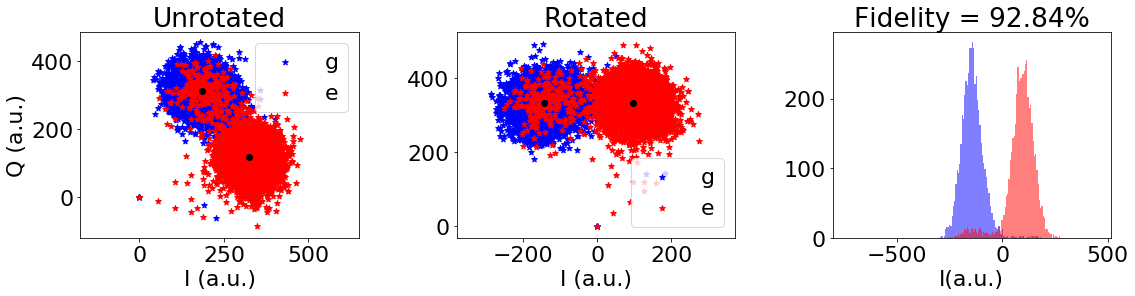

In [8]:
expt_cfg={
        "shots":5000, "res_phase":0
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs

ssp=SingleShotProgram(cfg=config)
di0, dq0, di1, dq1 = ssp.acquire(soc, load_pulses=True,progress=True, debug=False)

fid, threshold, angle = hist(data=[di0[0], dq0[0], di0[1], dq0[1]],  plot=True, ran=600)
#print('Optimal fidelity after rotation = %.3f' % fid)
readout_cfg["res_phase"]=deg2reg(-angle*180/pi)
readout_cfg["threshold"]=round(threshold)

# Pulse Probe (qubit) spectroscopy

In [9]:
# This program uses the RAveragerProgram class, which allows you to sweep a parameter directly on the processor 
# rather than in python as in the above example
# Because the whole sweep is done on the processor there is less downtime (especially for fast experiments)
class PulseProbeSpectroscopyProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_freq=self.sreg(cfg["qubit_ch"], "freq")   # get frequency register for qubit_ch    
        
        f_res=freq2reg(adcfreq(cfg["f_res"]))            # conver f_res to dac register value

        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2   #copy over adc acquisition parameters
        self.cfg["adc_freqs"]=[adcfreq(cfg["f_res"])]*2
        
        # add qubit and readout pulses to respective channels
        self.add_pulse(ch=self.cfg["qubit_ch"], name="qubit",style="const", length=self.cfg["probe_length"])
        self.add_pulse(ch=self.cfg["res_ch"], name="measure",style="const", length=self.cfg["readout_length"])
        self.f_start =freq2reg(cfg["start"])  # get start/step frequencies
        self.f_step =freq2reg(cfg["step"])
        
        # pre-initialize pulses
        self.pulse(ch=cfg["qubit_ch"], name="qubit", phase =0, freq=self.f_start, gain=cfg["qubit_gain"], play=False)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=f_res, phase=cfg['res_phase'], gain=cfg["res_gain"], play=False)
    
        self.sync_all(us2cycles(1))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"], play=True)  #play probe pulse
        self.sync_all(us2cycles(0.05)) # align channels and wait 50ns
        self.trigger_adc(adc1=1, adc2=1, adc_trig_offset=self.cfg["adc_trig_offset"])  #trigger measurement
        self.pulse(ch=self.cfg["res_ch"], play=True) # play measurement pulse
        self.sync_all(us2cycles(self.cfg["relax_delay"]))  # wait for qubit to relax
    
    def update(self):
        self.mathi(self.q_rp, self.r_freq, self.r_freq, '+', self.f_step) # update frequency list index

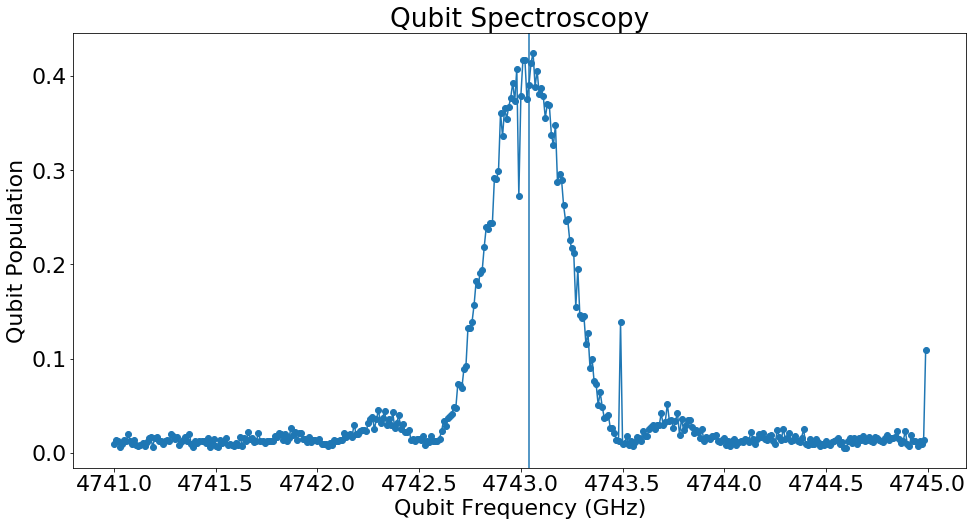

In [10]:
expt_cfg={"start":4741, "step":0.01, "expts":400, "reps": 20,"rounds":50,
          "probe_length":us2cycles(2), "qubit_gain":10
         }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs

qspec=PulseProbeSpectroscopyProgram(cfg=config)
expt_pts, avgi, avgq = qspec.acquire(soc, threshold=readout_cfg["threshold"],load_pulses=True,progress=True, debug=False)

subplot(111,title="Qubit Spectroscopy", xlabel="Qubit Frequency (GHz)", ylabel="Qubit Population")
plot(expt_pts, avgi[0][0],'o-')
axvline(qubit_cfg["f_ge"]);

# Length Rabi

In [11]:
class LengthRabiProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg

        
        cfg["adc_lengths"]=[cfg["readout_length"]]*2
        cfg["adc_freqs"]=[adcfreq(cfg["f_res"])]*2
        
        self.add_pulse(ch=cfg["qubit_ch"], name="qubit",style="const", length=cfg["pulse_length"])
        self.add_pulse(ch=cfg["res_ch"], name="measure",style="const", length=cfg["readout_length"])

        self.pulse(ch=cfg["qubit_ch"], name="qubit", phase=0, freq=freq2reg(cfg["f_ge"]), gain=cfg["qubit_gain"], play=False)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=freq2reg(adcfreq(cfg["f_res"])), phase=cfg['res_phase'], gain=cfg["res_gain"], play=False)
               
        self.synci(200)
        
    def body(self):
        cfg=self.cfg

        self.pulse(ch=cfg["qubit_ch"], play=True)
        self.sync_all(us2cycles(0.05))
        self.trigger_adc(adc1=1, adc2=1)
        self.pulse(ch=cfg["res_ch"], play=True)
        self.sync_all(us2cycles(self.cfg["relax_delay"]))

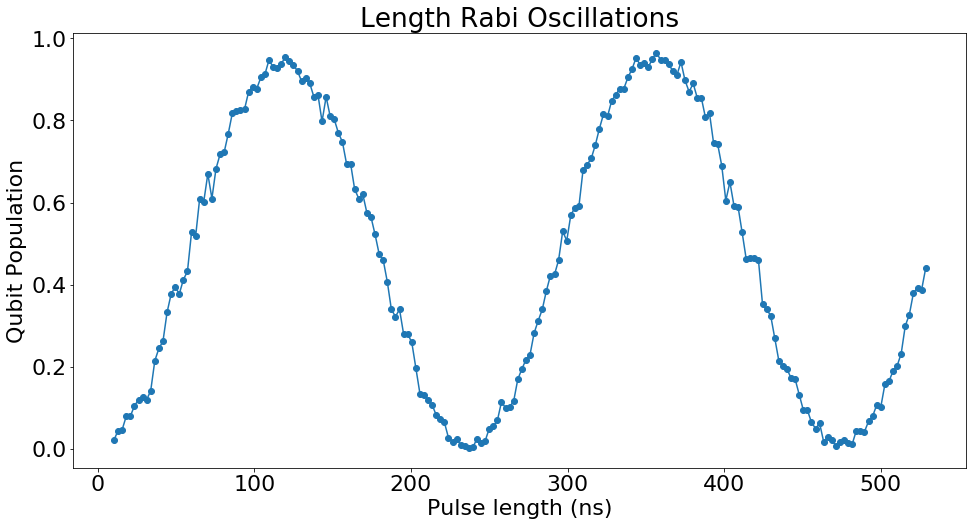

In [12]:
expt_cfg={
       "qubit_gain":2000,
        "start":4, "step":1, "expts":200, "reps": 400,
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs
expt_pts=[expt_cfg["start"] + ii*expt_cfg["step"] for ii in range(expt_cfg["expts"])]


results=[]
for length in tqdm(expt_pts):
    config["pulse_length"]=length

    rabi=LengthRabiProgram(config)
    avgi,avgq = rabi.acquire(soc, threshold=readout_cfg["threshold"], load_pulses=True, progress=False,debug=False)
    results.append(avgi[0][0])
    
subplot(111, title="Length Rabi Oscillations", xlabel="Pulse length (ns)", ylabel="Qubit Population")
plot(cycles2us(np.array(expt_pts))*1000,results,'o-');

# Amplitude Rabi

In [13]:
class AmplitudeRabiProgram(RAveragerProgram):

    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_gain=self.sreg(cfg["qubit_ch"], "gain")   # get gain register for qubit_ch    
        
        f_res=freq2reg(adcfreq(cfg["f_res"]))            # conver f_res to dac register value
        f_ge=freq2reg(cfg["f_ge"])
        
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2   #copy over adc acquisition parameters
        self.cfg["adc_freqs"]=[adcfreq(cfg["f_res"])]*2
        
        # add qubit and readout pulses to respective channels
        self.add_pulse(ch=self.cfg["qubit_ch"], name="qubit", style="arb", 
                       idata=gauss(mu=cfg["sigma"]*16*4/2,si=cfg["sigma"]*16,length=4*cfg["sigma"]*16,maxv=2**15-1), 
                       qdata=0*gauss(mu=cfg["sigma"]*16*4/2,si=cfg["sigma"]*16,length=4*cfg["sigma"]*16,maxv=2**15-1))
        self.add_pulse(ch=self.cfg["res_ch"], name="measure", style="const", length=self.cfg["readout_length"])
        
        # pre-initialize pulses
        self.pulse(ch=cfg["qubit_ch"], name="qubit", phase =0, freq=f_ge, gain=cfg["start"], play=False)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], play=False)
    
        self.sync_all(us2cycles(500))
    
    def body(self):
        
        self.pulse(ch=self.cfg["qubit_ch"], play=True, phase=deg2reg(90))  #play probe pulse
        self.sync_all(us2cycles(0.05)) # align channels and wait 50ns
        self.trigger_adc(adc1=1, adc2=1, adc_trig_offset=self.cfg["adc_trig_offset"])  #trigger measurement
        self.pulse(ch=self.cfg["res_ch"], name="measure", play=True) # play measurement pulse

        self.sync_all(us2cycles(self.cfg["relax_delay"]))  # wait for qubit to relax
    
    def update(self):
        self.mathi(self.q_rp, self.r_gain, self.r_gain, '+', self.cfg["step"]) # update gain of the Gaussian pi pulse

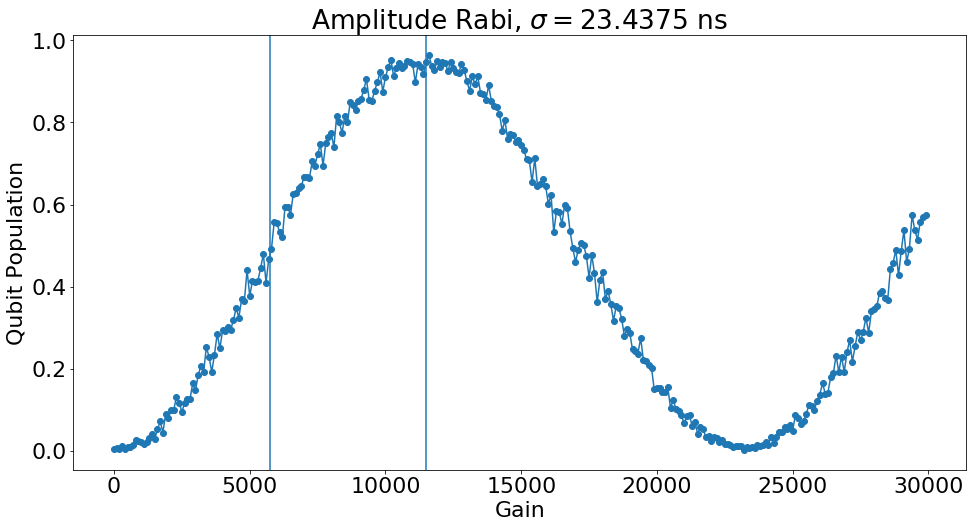

In [14]:
expt_cfg={
        "start":0, "step":100, "expts":300, "reps": 400
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs

rabi=AmplitudeRabiProgram(cfg=config)
x_pts, avgi, avgq  = rabi.acquire(soc,threshold=readout_cfg["threshold"], load_pulses=True,progress=True, debug=False)

subplot(111, title= f"Amplitude Rabi, $\sigma={cycles2us(config['sigma'])*1000}$ ns", xlabel="Gain", ylabel="Qubit Population" )
plot(x_pts,avgi[0][0],'o-')

axvline(qubit_cfg["pi_gain"])
axvline(qubit_cfg["pi2_gain"]);

# T1 

In [15]:
class T1Program(RAveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)       
        
    def initialize(self):
        cfg=self.cfg
        
        
        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_wait = 3
        self.regwi(self.q_rp, self.r_wait, cfg["start"])
               
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2   #copy over adc acquisition parameters
        self.cfg["adc_freqs"]=[adcfreq(cfg["f_res"])]*2
        
        # add qubit and readout pulses to respective channels
        self.add_pulse(ch=self.cfg["qubit_ch"], name="qubit",style="arb", idata=gauss(mu=cfg["sigma"]*16*4/2,si=cfg["sigma"]*16,length=4*cfg["sigma"]*16,maxv=2**15-1))
        self.add_pulse(ch=self.cfg["res_ch"], name="measure",style="const", length=self.cfg["readout_length"])
               
        # pre-initialize pulses
        self.pulse(ch=cfg["qubit_ch"], name="qubit", phase =0, freq=freq2reg(cfg["f_ge"]), gain=cfg["pi_gain"], play=False)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=freq2reg(adcfreq(cfg["f_res"])), phase=cfg['res_phase'], gain=cfg["res_gain"], play=False)
    
        self.sync_all(us2cycles(500))
    
    def body(self):
        
        self.pulse(ch=self.cfg["qubit_ch"], play=True)  #play probe pulse
        self.sync_all()
        self.sync(self.q_rp,self.r_wait)
        self.trigger_adc(adc1=1, adc2=1, adc_trig_offset=self.cfg["adc_trig_offset"])  #trigger measurement
        self.pulse(ch=self.cfg["res_ch"], name="measure", play=True) # play measurement pulse

        self.sync_all(us2cycles(self.cfg["relax_delay"]))  # wait for qubit to relax
    
    def update(self):
        self.mathi(self.q_rp, self.r_wait, self.r_wait, '+', us2cycles(self.cfg["step"])) # update frequency list index

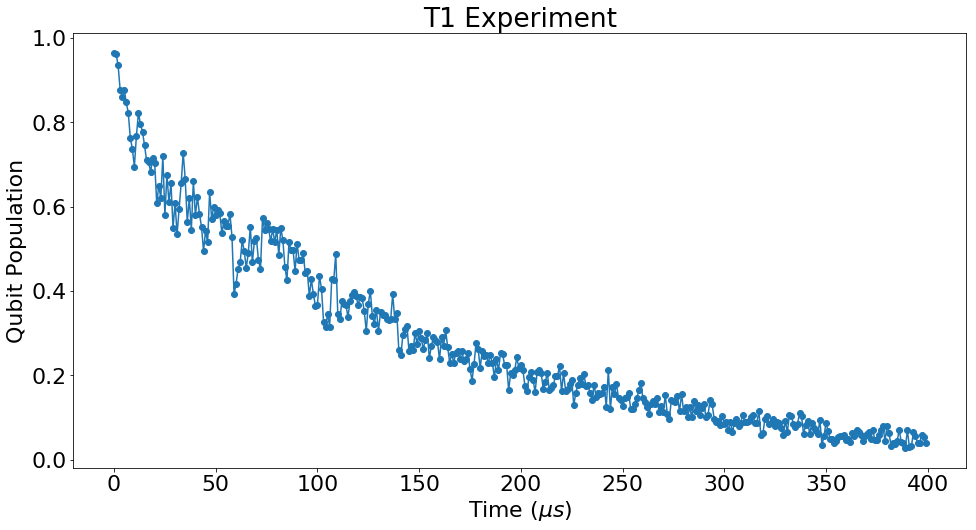

In [16]:
expt_cfg={ "start":0, "step":1, "expts":400, "reps": 400,
        "relax_delay":750
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs

t1p=T1Program(cfg=config)

x_pts, avgi, avgq = t1p.acquire(soc, threshold=readout_cfg["threshold"], load_pulses=True, progress=True, debug=False)
subplot(111, title="T1 Experiment", xlabel=f"Time ($\mu s$)", ylabel="Qubit Population")
plot(x_pts, avgi[0][0],'o-');

# Ramsey Fringe Experiment

In [17]:
class RamseyProgram(RAveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)       
        
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_wait = 3
        self.r_phase2 = 4
        self.r_phase=self.sreg(cfg["qubit_ch"], "phase")
        self.regwi(self.q_rp, self.r_wait, cfg["start"])
        self.regwi(self.q_rp, self.r_phase2, 0)
        
        f_res=freq2reg(adcfreq(cfg["f_res"]))            # conver f_res to dac register value
        f_ge=freq2reg(cfg["f_ge"])
        
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2   #copy over adc acquisition parameters
        self.cfg["adc_freqs"]=[adcfreq(cfg["f_res"])]*2
        
        # add qubit and readout pulses to respective channels
        self.add_pulse(ch=self.cfg["qubit_ch"], name="qubit", style="arb", idata=gauss(mu=cfg["sigma"]*16*4/2,si=cfg["sigma"]*16, length=4*cfg["sigma"]*16, maxv=2**15-1))
        self.add_pulse(ch=self.cfg["res_ch"], name="measure", style="const", length=self.cfg["readout_length"])
               
        # pre-initialize pulses
        self.pulse(ch=cfg["qubit_ch"], name="qubit", phase=0, freq=f_ge, gain=cfg["pi2_gain"], play=False)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=f_res, phase=cfg['res_phase'], gain=cfg["res_gain"], play=False)
    
        self.sync_all(us2cycles(0.2))
    
    def body(self):
        
        self.pulse(ch=self.cfg["qubit_ch"],phase=0, play=True)  #play probe pulse
        self.mathi(self.q_rp, self.r_phase, self.r_phase2,"+",0)
        self.sync_all()
        self.sync(self.q_rp,self.r_wait)
        self.pulse(ch=self.cfg["qubit_ch"], play=True)  #play probe pulse
        self.sync_all(us2cycles(0.05))
        self.trigger_adc(adc1=1, adc2=1, adc_trig_offset=self.cfg["adc_trig_offset"])  #trigger measurement
        self.pulse(ch=self.cfg["res_ch"], name="measure", play=True) # play measurement pulse
        self.sync_all(us2cycles(self.cfg["relax_delay"]))  # wait for qubit to relax
    
    def update(self):
        self.mathi(self.q_rp, self.r_wait, self.r_wait, '+', self.cfg["step"]) # update the time between two π/2 pulses
        self.mathi(self.q_rp, self.r_phase2, self.r_phase2, '+', self.cfg["phase_step"]) # advance the phase of the LO for the second π/2 pulse

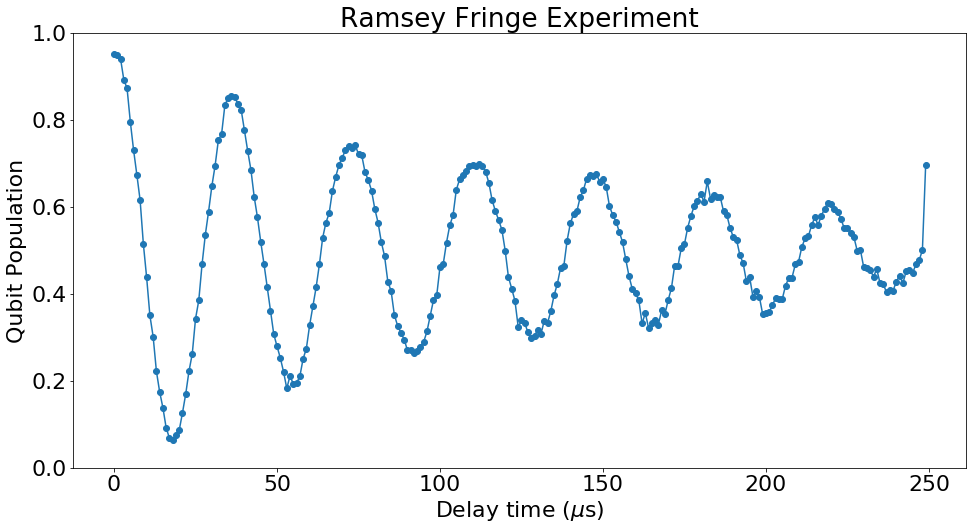

In [18]:
expt_cfg={"start":us2cycles(0.0), "step":us2cycles(1), "phase_step": deg2reg(2*360/100), "expts":250,
          "reps": 10, "rounds": 200
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs
t2p=RamseyProgram(cfg=config)
x_pts, avgi, avgq= t2p.acquire(soc, threshold=readout_cfg["threshold"], load_pulses=True,progress=True, debug=False)

subplot(111, title="Ramsey Fringe Experiment", xlabel="Delay time ($\mu$s)", ylabel="Qubit Population")
plot(cycles2us(x_pts),avgi[0][0],'o-')
ylim(0,1);

# Active reset

In [19]:
class ActiveResetProgram(RAveragerProgram):        
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_gain=self.sreg(cfg["qubit_ch"], "gain")   # get frequency register for qubit_ch  
        
        self.r_gain2=4
        self.regwi(self.q_rp, self.r_gain2, cfg["start"])        
        
        f_res=freq2reg(adcfreq(cfg["f_res"]))            # conver f_res to dac register value
        f_ge=freq2reg(cfg["f_ge"])
        
        self.r_thresh = 6
        self.regwi(0,self.r_thresh,config["threshold"]*cfg["readout_length"])
        
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2   #copy over adc acquisition parameters
        self.cfg["adc_freqs"]=[adcfreq(cfg["f_res"])]*2
        
        # add qubit and readout pulses to respective channels
        self.add_pulse(ch=self.cfg["qubit_ch"], name="qubit",style="arb", idata=gauss(mu=cfg["sigma"]*16*5/2,si=cfg["sigma"]*16,length=5*cfg["sigma"]*16,maxv=2**15-1))
        self.add_pulse(ch=self.cfg["res_ch"], name="measure",style="const", length=self.cfg["readout_length"])
               
        # pre-initialize pulses
        self.pulse(ch=cfg["qubit_ch"], name="qubit", phase =0, freq=f_ge, gain=cfg["start"], play=False)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], play=False)
    
        self.sync_all(us2cycles(500))
    
    def body(self):
        
        self.mathi(self.q_rp,self.r_gain,self.r_gain2,"+",0)
        self.pulse(ch=self.cfg["qubit_ch"], play=True)  #play probe pulse
        self.sync_all(us2cycles(0.05))
        
        self.trigger_adc(adc1=1, adc2=1, adc_trig_offset=self.cfg["adc_trig_offset"])  #trigger measurement
        self.pulse(ch=self.cfg["res_ch"], name="measure", play=True) # play measurement pulse
        self.waiti(1, self.cfg["readout_length"]+500)
        self.read(0,0,"lower",2)
        self.read(0,0,"upper",3)

        self.condj(0,2,'<',self.r_thresh,'after_reset')
        self.pulse(ch=self.cfg["qubit_ch"], gain=self.cfg["pi_gain"], t=0, play=True)  #pi pulse qubit
        self.label('after_reset')

        self.sync_all(us2cycles(1)) # align channels and wait 50ns
        self.trigger_adc(adc1=1, adc2=1, adc_trig_offset=self.cfg["adc_trig_offset"])  #trigger measurement
        self.pulse(ch=self.cfg["res_ch"], name="measure", play=True) # play measurement pulse

        self.sync_all(us2cycles(self.cfg["relax_delay"]))  # wait for qubit to relax
    
    def update(self):
        self.mathi(self.q_rp, self.r_gain2, self.r_gain2, '+', self.cfg["step"]) # update frequency list index
        

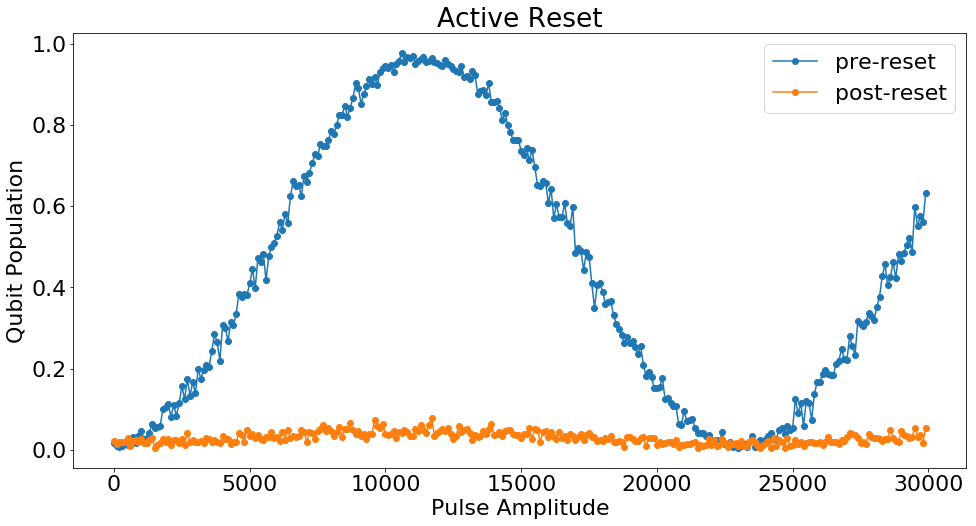

In [20]:
expt_cfg={
        "start":0, "step":100, "expts":300, "reps": 400
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs

areset=ActiveResetProgram(cfg=config)
expt_pts,avgi,avgq = areset.acquire(soc, threshold=readout_cfg["threshold"], readouts_per_experiment=2, save_experiments=[0,1], load_pulses=True, progress=True)

subplot(111,title="Active Reset", xlabel="Pulse Amplitude", ylabel="Qubit Population")
plot(expt_pts,avgi[0][0],'o-', label="pre-reset")
plot(expt_pts,avgi[0][1], 'o-', label="post-reset")
legend();